Gordon L
# Lab 10
Understanding Docker Networks

What is Container Networking?
Container networking also called Software Defined Networking (SDN) is what allows Docker networkgin subsystems to work. 

Some defalt Docker Netwrok drivers are:
- Bridge
    - a Network that is User-defined to allow for all containers connected on the same network to communicate with eachother. 
- Host
    - a container is attahed to a Docker host. Any traffic routed to the container must be routed from the host system.
- Overlay
    - Created in a network spanning multiple docker hosts. Think each of your docker containers in the lab talking to eachother
- Macvlan
    - used in complicated networking to assing logical addresses based on MAC addresses to the virtual network interfaces making it apear as if the container has a physical network interaface connected to the network. Used in legacy applications.
- None
    -  the container only has a loopback interface so it can talk to itself.



# Part 1 - Setup

In [ ]:
!docker run -d --name nginx --network=none -p 81:81 nginx

cbb2f01cd1b1f17d502470e765159bc3400ca19f6862028bbc0ebb2c065f8183


## Note:
**If you get this error:**

*docker: permission denied while trying to connect to the Docker daemon ...*

run this in wsl: 
``` bash
sudo usermod -aG docker $USER
newgrp docker
sudo systemctl restart docker
```
Run it again....

you should get a hash number YAY!

`cbb2f01cd1b...`

--------------------------------------
If you are still getting the error


run this:
``` bash
sudo chmod 666 /usr/docker.sock
```
--------------------------------------
**If you get this error you did things right**

docker: Error response from daemon: Conflict. The container name "/nginx

--------------------------------------


## we now have an nginx container 

NGINX serves static content (like HTML, CSS, JavaScript, images) efficiently, improving website performance.

In [ ]:
!curl localhost

#the curl command should fail on our system 

/bin/bash: line 1: curl: command not found


Lets run it on the docker container 

In [19]:
!docker exec -it nginx2 /bin/sh -c "curl google.com"



curl: (6) Could not resolve host: google.com


* curl:(6) Could not resolve host: google.com

As you can see the nginx container can not talk to google.com

# Part 2 - Understanding the network 
Docker comes with a subcommand for handling Docker networks.

In [ ]:
!docker 

#8acb7063e5648720e71dbcbb04bca38c0454ed0985a9ed3a33063e9236a2e223


Usage:  docker network COMMAND

Manage networks

Commands:
  connect     Connect a container to a network
  create      Create a network
  disconnect  Disconnect a container from a network
  inspect     Display detailed information on one or more networks
  ls          List networks
  prune       Remove all unused networks
  rm          Remove one or more networks

Run 'docker network COMMAND --help' for more information on a command.


running `docker network ls` will show us all the names of the networks.


In [ ]:
!docker network ls 

NETWORK ID     NAME      DRIVER    SCOPE
d2b08c95b890   bridge    bridge    local
d873972cad3b   host      host      local
f7b0737ec118   none      null      local


In the above you can see that there is a none network. 

When we setup the docker nginx server we did not give it a network

lets look for the nginx server

In [23]:
!docker network inspect none 

[
    {
        "Name": "none",
        "Id": "f7b0737ec1188b800684be7edfaea4ba5d2871bc12f00933bf55712a110ee27d",
        "Created": "2025-04-18T12:24:26.478234728-07:00",
        "Scope": "local",
        "Driver": "null",
        "EnableIPv6": false,
        "IPAM": {
            "Driver": "default",
            "Options": null,
            "Config": null
        },
        "Internal": false,
        "Attachable": false,
        "Ingress": false,
        "ConfigFrom": {
            "Network": ""
        },
        "ConfigOnly": false,
        "Containers": {
            "cbb2f01cd1b1f17d502470e765159bc3400ca19f6862028bbc0ebb2c065f8183": {
                "Name": "nginx2",
                "EndpointID": "64ba2adbfd4b93f0be8a480f884b4417c5e69f2f221294786f127342b46cf6b8",
                "MacAddress": "",
                "IPv4Address": "",
                "IPv6Address": ""
            }
        },
        "Options": {},
        "Labels": {}
    }
]


## OK Enough of that nonsense
Lets install docker and use the API to do some work this is a python class after all

In [25]:
!pip install docker

Defaulting to user installation because normal site-packages is not writeable
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 147.8/147.8 kB 832.3 kB/s eta 0:00:00a 0:00:01


In [ ]:
import docker

client = docker.from_env()

print("Docker version:", client.version()['Version'])


: 

Lets create a quick code to list the containers using the docker client

In [ ]:
def list_running_containers():
    containers = client.containers.list(all=True)# list all containers
    #containers = client.containers.list() #list only running containers
    for container in containers:
        print(f"{container.name} - {container.status}")

list_running_containers()

: 

Here you can see the running container and no surprise it is the nginx we started before


In [ ]:
#lest identify the network of the nginx container
def show_container_ip(container_name):
    container = client.containers.get(container_name)
    networks = container.attrs['NetworkSettings']['Networks']
    
    for net_name, net_data in networks.items():
        print(f"{container_name} in network '{net_name}' has IP: {net_data['IPAddress']}")


show_container_ip("nginx")


nginx2 in network 'none' has IP: 


again no surprise there is no IP address as it does not have a network. 

### ok I lied back to creating more stuff though the CLI

In [ ]:
#setup another container for mysql
!docker run -d --name mysql -p 3306:3306 -e MYSQL_ROOT_PASSWORD=1 mysql:8
#Note the -d means detached mode so no container is using created just the MySQL database 

Unable to find image 'mysql:8' locally
8: Pulling from library/mysql

72a6e83b: Pulling fs layer 
8f7bea3b: Pulling fs layer 
c4c227a4: Pulling fs layer 
6885cc1f: Pulling fs layer 
a68c5921: Pulling fs layer 
f079852f: Pulling fs layer 
287da18a: Pulling fs layer 
571eacc0: Pulling fs layer 
39f5bee3: Pulling fs layer 
4e5cd318: Pull complete .33kB/5.33kBBBADigest: sha256:3a89257a3a979e46e3650628bea227a6bc318a2bdc95f954489ec89573a4c6a2
Status: Downloaded newer image for mysql:8
027c1da3b4d506bec8858248eb85963873771631b77afae41b140d85a25ca4f8
2025-04-18 20:36:45+00:00 [Note] [Entrypoint]: Entrypoint script for MySQL Server 8.4.5-1.el9 started.
2025-04-18 20:36:45+00:00 [Note] [Entrypoint]: Switching to dedicated user 'mysql'
2025-04-18 20:36:45+00:00 [Note] [Entrypoint]: Entrypoint script for MySQL Server 8.4.5-1.el9 started.
2025-04-18 20:36:45+00:00 [Note] [Entrypoint]: Initializing database files
2025-04-18T20:36:45.900060Z 0 [System] [MY-015017] [Server] MySQL Server Initialization

## The following needs to be run in the terminal

In [49]:
!docker run -d --name adminer -p 8080:8080 adminer


c310d01f7f122a768fec334f06b2dd8b1459015c1fa046b0304ca8d54a9ceb8c


Run the following each in there own terminal

``` bash
docker logs -f mysql
docker logs -f adminer
```

In [41]:
!docker inspect mysql | grep -n1 "IPAddress\":"
# or
print("-"*30)
show_container_ip("mysql")


216-            "GlobalIPv6PrefixLen": 0,
217:            "IPAddress": "172.17.0.2",
218-            "IPPrefixLen": 16,
--
229-                    "Gateway": "172.17.0.1",
230:                    "IPAddress": "172.17.0.2",
231-                    "IPPrefixLen": 16,
------------------------------
mysql in network 'bridge' has IP: 172.17.0.2


In [42]:
!docker inspect adminer| grep  -n1 "IPAddress\":"
# or
print("-"*30)
show_container_ip("adminer")


220-            "GlobalIPv6PrefixLen": 0,
221:            "IPAddress": "172.17.0.3",
222-            "IPPrefixLen": 16,
--
233-                    "Gateway": "172.17.0.1",
234:                    "IPAddress": "172.17.0.3",
235-                    "IPPrefixLen": 16,
------------------------------
adminer in network 'bridge' has IP: 172.17.0.3


### Lets do a bit of cleanup 

``` bash
#lets remove our old container
!docker stop adminer
!docker rm adminer
!docker stop mysql
!docker rm mysql
!docker stop nginx 
!docker rm nginx
```

In [51]:
def clean_containers():
    containers = client.containers.list(all=True)
    if not containers:
        print("No containers to clean.")
        return
    
    for container in containers:
        container.stop()
        print(f"Waiting for {container.name} to stop...")
        while container.status != 'exited':
            pass
        
        container.reload()
        if container.status == 'exited':
            print(f"Removing {container.name}")
            container.remove()

list_running_containers()

clean_containers()


No containers to clean.


## Setting up the network

In [1]:
# Create a network called yourNetwork using the following command

!docker network create yourNetwork

431d092aa909f50dab25f1d2dc5eef9c97b516314e2bb79519d8198541843e8c


In [2]:
!docker network inspect yourNetwork

[
    {
        "Name": "yourNetwork",
        "Id": "431d092aa909f50dab25f1d2dc5eef9c97b516314e2bb79519d8198541843e8c",
        "Created": "2025-04-18T14:36:24.265817696-07:00",
        "Scope": "local",
        "Driver": "bridge",
        "EnableIPv6": false,
        "IPAM": {
            "Driver": "default",
            "Options": {},
            "Config": [
                {
                    "Subnet": "172.18.0.0/16",
                    "Gateway": "172.18.0.1"
                }
            ]
        },
        "Internal": false,
        "Attachable": false,
        "Ingress": false,
        "ConfigFrom": {
            "Network": ""
        },
        "ConfigOnly": false,
        "Containers": {},
        "Options": {},
        "Labels": {}
    }
]


In [ ]:
!docker run -d --network yourNetwork --name mysql -p 3306:3306 -e MYSQL_ROOT_PASSWORD=1 mysql:8


#7a8def07c52b5fdba523615ec8e05d8f011dd686556be9849e8adeac0dd73a49


b5bcdf9fdee61ea1de797aa354e1f332c31ff095d1f2390319ff36f7fc36397b


In [ ]:
!docker run -d --network yourNetwork --name adminer -p 8080:8080 adminer


#65e8f3482b4d159ce3b37147c7ece7442f2ee08ca11cc48a0d75ed659f17fe8a


a96cb2039f9ca306043e6584c324b684156f1fca0b19ae63bf4108895642d665


In [5]:
#Now lets connect the adminer
!docker network connect yourNetwork adminer

Error response from daemon: endpoint with name adminer already exists in network yourNetwork


In [ ]:
!docker inspect mysql |grep -C2 " \"Networks\""
!docker inspect mysql |grep -A9 " \"Networks\""| grep " \"IPAddress\""
#or
print("-"*30)
show_container_ip("mysql")


# empty :(
# "IPv6Gateway": "",
#             "MacAddress": "",
#             "Networks": {
#                 "yourNetwork": {
#                     "IPAMConfig": null,

            "IPv6Gateway": "",
            "MacAddress": "",
            "Networks": {
                "yourNetwork": {
                    "IPAMConfig": null,
                    "IPAddress": "172.18.0.2",
------------------------------


NameError: name 'show_container_ip' is not defined

In [27]:
!docker inspect adminer| grep -A2 " \"Networks\""
!docker inspect adminer| grep -A9 " \"Networks\""| grep " \"IPAddress\""
!ping -c 1 172.18.0.3
#or
print("-"*30)
show_container_ip("adminer")

            "Networks": {
                "yourNetwork": {
                    "IPAMConfig": null,
                    "IPAddress": "172.18.0.3",
PING 172.18.0.3 (172.18.0.3) 56(84) bytes of data.
64 bytes from 172.18.0.3: icmp_seq=1 ttl=64 time=0.063 ms

--- 172.18.0.3 ping statistics ---
1 packets transmitted, 1 received, 0% packet loss, time 0ms
rtt min/avg/max/mdev = 0.063/0.063/0.063/0.000 ms
------------------------------


NameError: name 'show_container_ip' is not defined

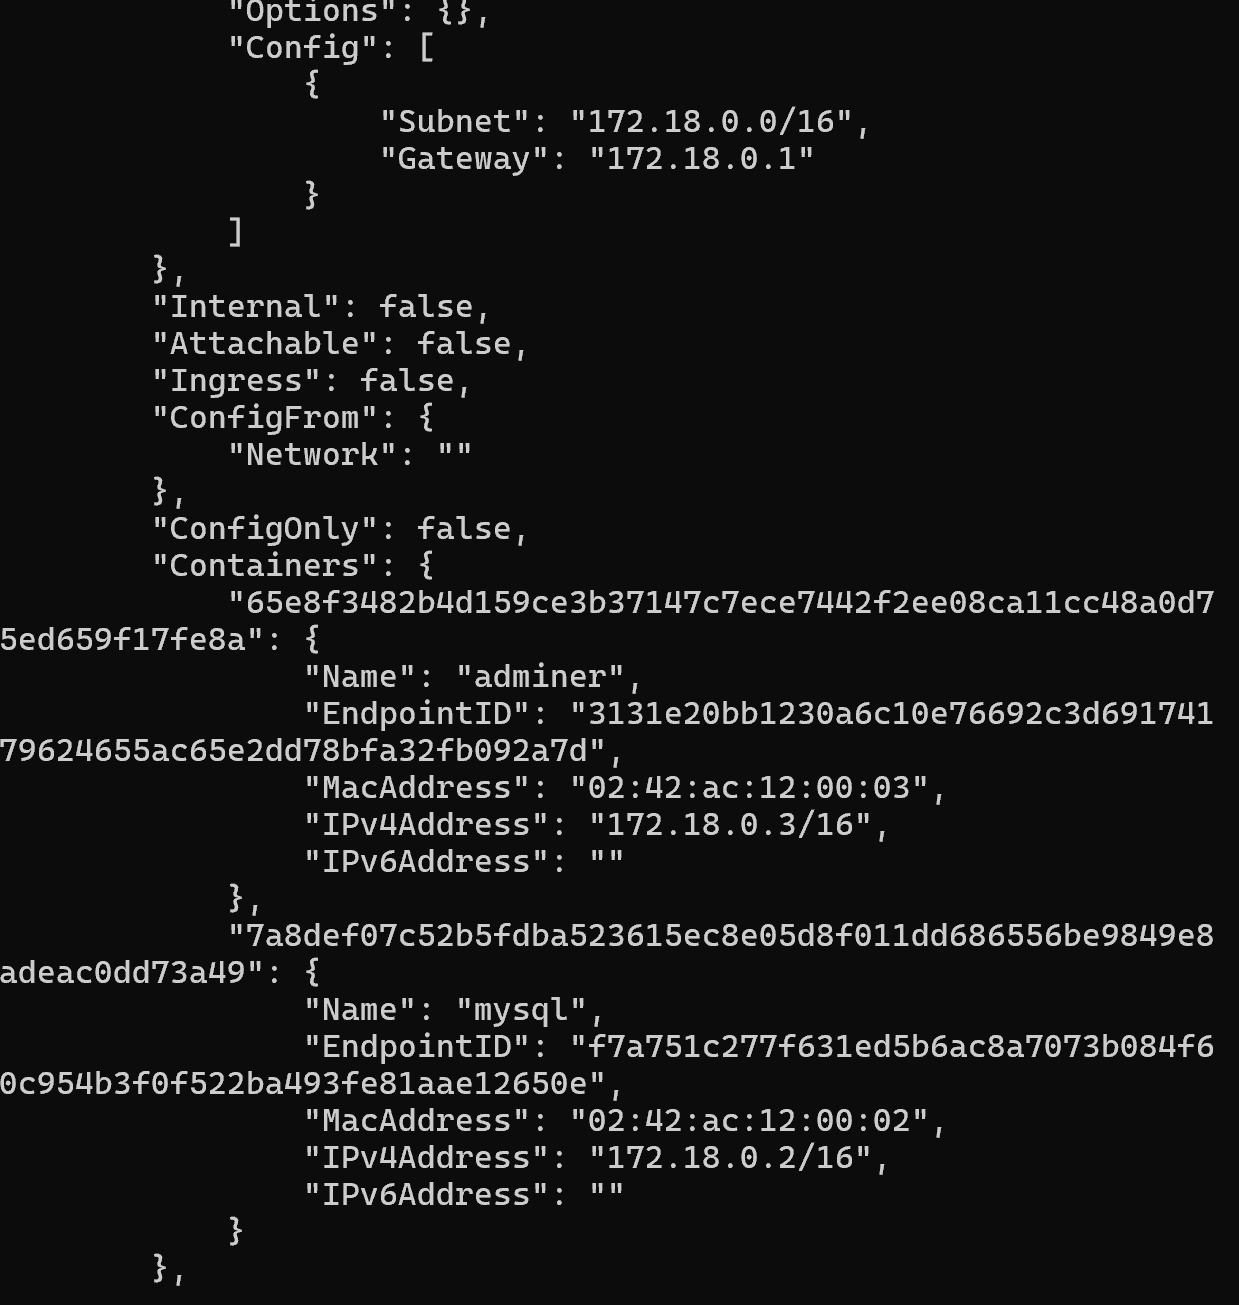



# LAB 
As a reminder you should be submitting to me 2 files. 
- _YourName_Lab 09.ipynb
    - this is your lab report
- _YourName__\<name of your script\>.py

## Part 1 - warm up

Now that you have 2 containers up and running and know there connected. Create a python script that will check to see if the IP addresses of the containers are up and running. 



In [ ]:
import docker

client = docker.from_env()

print("Docker version:", client.version()['Version'])



def show_container_ip(container_name):
    container = client.containers.get(container_name)
    networks = container.attrs['NetworkSettings']['Networks']
    
    for net_name, net_data in networks.items():
        print(f"{container_name} in network '{net_name}' has IP: {net_data['IPAddress']}")


show_container_ip("adminer")
show_container_ip("mysql")


# I broke my notebook kernel :((



: 

# Terminal output
``` bash
Docker version: 27.5.1
adminer in network 'yourNetwork' has IP: 172.18.0.3
mysql in network 'yourNetwork' has IP: 172.18.0.2
```


## Part 2
Continue with the above code and create a script that will:
- Relaunch a container if it is ever shutdown. 



### removed this these steps
- Perform a maintenance restart after 1 day has passed. 
- Monitor the log files and outputs errors and warnings.

your python file does not need to be in a docker container


https://docs.docker.com/engine/api/sdk/examples/



In [ ]:
import docker
import time
import threading
import logging


client = docker.from_env()
containers = ["adminer", "mysql"]

# taken from notes
logger = logging.getLogger()

logger.setLevel(logging.INFO) # set the logging level to INFO

formatter = logging.Formatter(
    fmt=(
        "%(asctime)s | %(levelname)s | "
        "%(message)s"
    )
)
handler = logging.handlers.TimedRotatingFileHandler(
    filename="formatedLog.log",
    when="D",
    backupCount=3,
)
# create a file handler that logs to a file
logger.addHandler(
    logging.handlers.TimedRotatingFileHandler(
        filename="archived_log.log", #file name
        when="D", #rolls the log every day
        backupCount=3, # only keep 3 days worth of file backups
    )
)

# used https://docker-py.readthedocs.io/en/stable/containers.html




def start_shutdown_check():

    while True:
        time.sleep(10)
        # check if containers are running every 10 secs
        for containerName in containers:
            container = client.containers.get(containerName)

            if container.status != "running":
                # if not running, start the container
                container.start()
                print(f"Container {containerName} started at {time.strftime('%H:%M:%S')}")
            # restart at hour 1  
            if time.strftime("%H") == "01":
                container.restart()
                print(f"Container {containerName} restarted at {time.strftime('%H:%M:%S')}")


    

if __name__ == "__main__":
    shutdown_thread = threading.Thread(target=start_shutdown_check)
    shutdown_thread.start()

    # wanted to make another thread that would open the log stream and print it

    










